In [ ]:
#hellow welcome to my note i am kashish contributing stingray.jl

In [3]:
using Pkg
Pkg.add(["Plots", "Interpolations", "LinearAlgebra", "Colors", "Statistics","StatsPlots"])


    Updating registry at `C:\Users\asus4\.julia\registries\General.toml`
   Resolving package versions...
   Installed OpenMPI_jll ─ v5.0.7+1
  No Changes to `C:\Users\asus4\.julia\environments\v1.7\Project.toml`
    Updating `C:\Users\asus4\.julia\environments\v1.7\Manifest.toml`
  [fe0851c0] ↑ OpenMPI_jll v5.0.7+0 ⇒ v5.0.7+1
Precompiling project...
  ✓ OpenMPI_jll
  ✓ HDF5_jll
  ✓ HDF5
  ✓ Stingray
  4 dependencies successfully precompiled in 37 seconds (242 already precompiled)


In [4]:
#these are the function having there test cases

Testing _get_rms_span_functions
x: -20 -> ymin: 0.3, ymax: 0.7
x: 0 -> ymin: 0.3, ymax: 0.7
x: 10 -> ymin: 0.3, ymax: 0.6
x: 40 -> ymin: 0.25, ymax: 0.4
x: 100 -> ymin: 0.25, ymax: 0.35
x: 150 -> ymin: 0.2, ymax: 0.3
x: 170 -> ymin: 0.0, ymax: 0.3
x: 200 -> ymin: 0.0, ymax: 0.15
x: 370 -> ymin: 0.0, ymax: 0.15


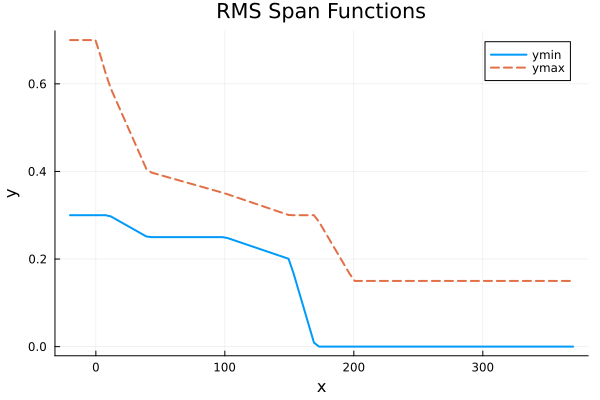

In [2]:
using Plots
using Interpolations
using LinearAlgebra
using Colors
using Statistics
using StatsPlots  # Import StatsPlots for error bars
using DataFrames  # Import DataFrames to handle error bars

DEFAULT_COLOR_CONFIGURATION = Dict(
    "center" => [4.51920, 0.453724],
    "ref_angle" => 3 * pi / 4,
    "state_definitions" => Dict(
        "HSS" => Dict("hue_limits" => [300, 360], "color" => "red"),
        "LHS" => Dict("hue_limits" => [-20, 140], "color" => "blue"),
        "HIMS" => Dict("hue_limits" => [140, 220], "color" => "green"),
        "SIMS" => Dict("hue_limits" => [220, 300], "color" => "yellow")
    ),
    "rms_spans" => Dict(
        -20 => [0.3, 0.7],
        0 => [0.3, 0.7],
        10 => [0.3, 0.6],
        40 => [0.25, 0.4],
        100 => [0.25, 0.35],
        150 => [0.2, 0.3],
        170 => [0.0, 0.3],
        200 => [0, 0.15],
        370 => [0, 0.15]
    )
)

function _get_rms_span_functions(configuration=DEFAULT_COLOR_CONFIGURATION)
    rms_spans = configuration["rms_spans"]

    # Extract and sort unique x-values
    x = sort(unique(collect(keys(rms_spans))))
    ymin = [rms_spans[x_val][1] for x_val in x]
    ymax = [rms_spans[x_val][2] for x_val in x]

    # Create interpolation functions
    ymin_func = LinearInterpolation(x, ymin, extrapolation_bc=Flat())
    ymax_func = LinearInterpolation(x, ymax, extrapolation_bc=Flat())

    return ymin_func, ymax_func
end

# Test the function by printing values
println("Testing _get_rms_span_functions")
ymin_func, ymax_func = _get_rms_span_functions()

test_values = [-20, 0, 10, 40, 100, 150, 170, 200, 370]
for val in test_values
    println("x: ", val, " -> ymin: ", ymin_func(val), ", ymax: ", ymax_func(val))
end

# Plot the functions to visualize
x_vals = range(-20, stop=370, length=100)
plot(x_vals, ymin_func.(x_vals), label="ymin", lw=2)
plot!(x_vals, ymax_func.(x_vals), label="ymax", lw=2, linestyle=:dash)
title!("RMS Span Functions")
xlabel!("x")
ylabel!("y")


In [6]:
#rms_hue_plot note this particular part of code failss in test 4 devlopment is going on i have asked this in julia slack

Testing _create_rms_hue_plot...
Test 1: Basic plot without spans - Success


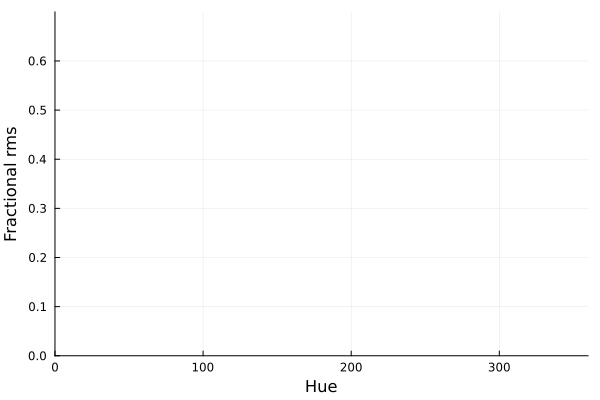

Test 2: Plot with spans - Success


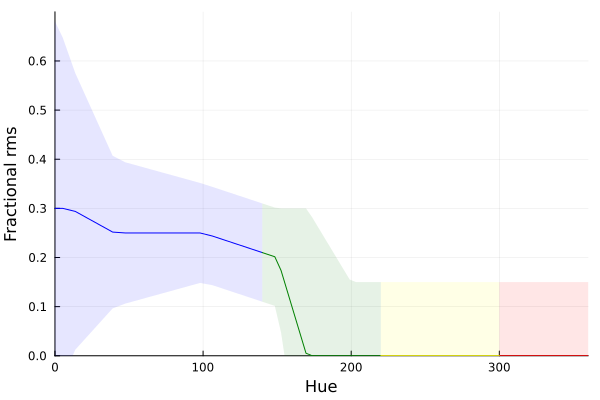

Test 3: Polar plot without spans - Success


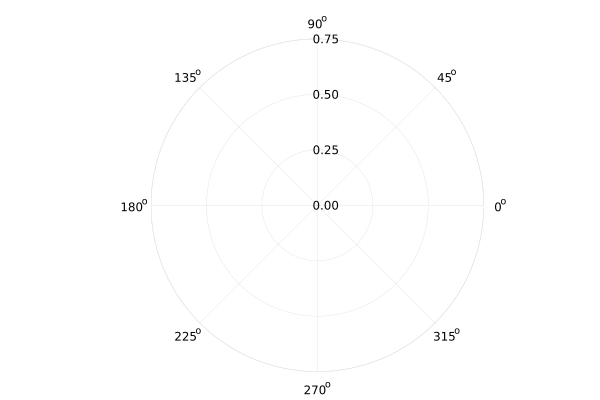

Test 4: Polar plot with spans - Success


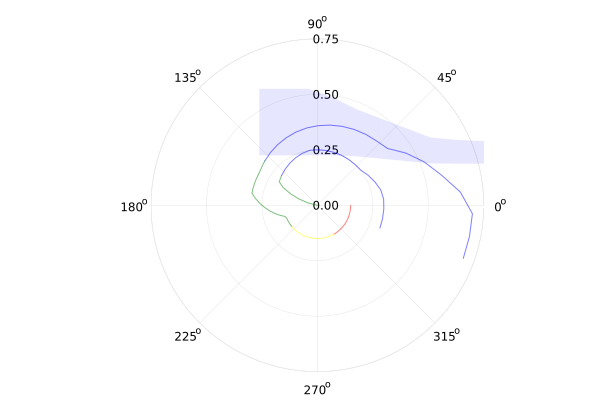

All tests completed successfully.


In [4]:
function _create_rms_hue_plot(; polar=false, plot_spans=false, configuration=DEFAULT_COLOR_CONFIGURATION)
    if polar
        fig = plot(proj=:polar)
        ylims!(fig, (0.0, 0.75))
        yticks!(fig, [0, 0.25, 0.5, 0.75, 1])
        plot!(fig, grid=true)
    else
        fig = plot(xlims=(0, 360), ylims=(0.0, 0.7), xlabel="Hue", ylabel="Fractional rms")
    end
    if !plot_spans
        return fig
    end
    ymin_func, ymax_func = get_rms_span_functions(configuration)
    for (state, details) in configuration["state_definitions"]
        color = parse(Colorant, details["color"])
        xmin, xmax = details["hue_limits"]
        
        xs = collect(range(xmin, stop=xmax, length=20))
        
        if polar
            # For polar plots, handle each point individually to avoid broadcasting issues
            xs_rad = [deg2rad(x) for x in xs]
            y_mins = [ymin_func(x) for x in xs]
            y_maxs = [ymax_func(x) for x in xs]
            
            # Plot the minimum line
            plot!(fig, xs_rad, y_mins, color=color, label="", alpha=0.5)
            # Plot the maximum line
            plot!(fig, xs_rad, y_maxs, color=color, label="", alpha=0.5)
            # Fill between the lines
            for i in 1:(length(xs)-1)
                x_section = [xs_rad[i], xs_rad[i+1], xs_rad[i+1], xs_rad[i]]
                y_section = [y_mins[i], y_mins[i+1], y_maxs[i+1], y_maxs[i]]
                plot!(fig, x_section, y_section, seriestype=:shape, color=color, fillalpha=0.1, linewidth=0, label="")
            end
        else
            # For Cartesian plots, standard approach works
            ymin_vals = [ymin_func(x) for x in xs]
            ymax_vals = [ymax_func(x) for x in xs]
            # Calculate ribbon values explicitly
            ribbon_vals = [ymax - ymin for (ymax, ymin) in zip(ymax_vals, ymin_vals)]
            plot!(fig, xs, ymin_vals, ribbon=ribbon_vals, fillalpha=0.1, color=color, label="")
        end
    end
    return fig
end


# Test function for _create_rms_hue_plot
println("Testing _create_rms_hue_plot...")

# Test 1: Basic plot without spans
fig1 = _create_rms_hue_plot()
println("Test 1: Basic plot without spans - Success")

display(fig1)

# Test 2: Plot with spans
fig2 = _create_rms_hue_plot(plot_spans=true)
println("Test 2: Plot with spans - Success")

display(fig2)

# Test 3: Polar plot without spans
fig3 = _create_rms_hue_plot(polar=true)
println("Test 3: Polar plot without spans - Success")

display(fig3)

# Test 4: Polar plot with spans
fig4 = _create_rms_hue_plot(polar=true, plot_spans=true)
println("Test 4: Polar plot with spans - Success")

display(fig4)

println("All tests completed successfully.")

In [5]:
using Plots

function polar_rms_plot_with_spans(state_definitions, hue_vals, rms_vals; title="Polar Fractional RMS Plot")
    """
    Generate a polar plot of fractional RMS with background state spans.

    Parameters
    ----------
    state_definitions : Dict
        Dictionary containing hue limits and colors for different states.
    hue_vals : Vector{Float64}
        Hues (in degrees) for the fractional RMS values.
    rms_vals : Vector{Float64}
        Corresponding fractional RMS values.

    Returns
    -------
    fig : Plot
        The generated polar plot.
    """

    # Convert hues from degrees to radians
    hues_rad = deg2rad.(hue_vals)

    # Create Polar Plot
    fig = plot(proj=:polar, legend=false, title=title, ylim=(0, 0.6))

    # Plot background state spans
    for (state, params) in state_definitions
        hue_min, hue_max = params["hue_limits"]
        color = params["color"]
        
        # Convert hue limits to radians
        theta1, theta2 = deg2rad(hue_min), deg2rad(hue_max)
        
        # Define radial (fractional RMS) span
        r_vals = [0.0, 0.6, 0.6, 0.0]
        theta_vals = [theta1, theta1, theta2, theta2]
        
        # Plot the background span
        plot!(theta_vals, r_vals, fillalpha=0.15, lw=0, color=color, label="")
    end

    # Plot the fractional RMS curve
    plot!(hues_rad, rms_vals, linewidth=2, color=:blue, label="Fractional RMS")

    return fig
end


polar_rms_plot_with_spans (generic function with 1 method)

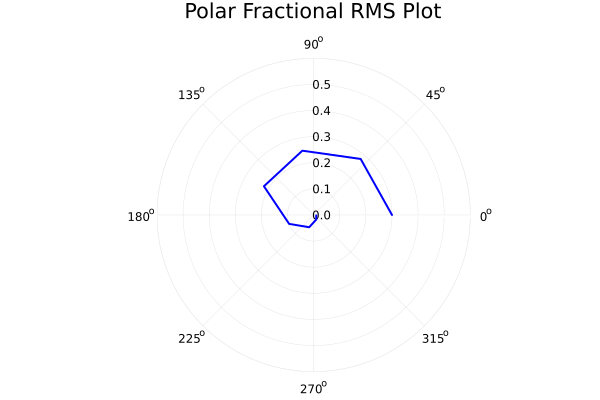

In [54]:
# Define background state definitions (colored spans)
state_definitions = Dict(
    "HSS" => Dict("hue_limits" => [300.0, 360.0], "color" => :red),
    "LHS" => Dict("hue_limits" => [-20.0, 140.0], "color" => :blue),
    "HIMS" => Dict("hue_limits" => [140.0, 220.0], "color" => :green),
    "SIMS" => Dict("hue_limits" => [220.0, 300.0], "color" => :yellow)
)

# Sample test data (Hues in degrees and corresponding RMS values)
hue_vals = [0, 50, 100, 150, 200, 250, 300, 350]  # Degrees
rms_vals = [0.3, 0.28, 0.25, 0.22, 0.1, 0.05, 0.02, 0.01]  # Example fractional RMS

# Generate and display the polar plot
fig = polar_rms_plot_with_spans(state_definitions, hue_vals, rms_vals)
display(fig)


In [59]:
using Plots

function polar_rms_scatter_with_hues(state_definitions, pc1_vals, pc2_vals, rms_vals; title="Polar Power Color Hue Plot")
    """
    Generate a polar scatter plot of power color hues with background state spans.

    Parameters
    ----------
    state_definitions : Dict
        Dictionary containing hue limits and colors for different states.
    pc1_vals : Vector{Float64}
        First power color component values.
    pc2_vals : Vector{Float64}
        Second power color component values.
    rms_vals : Vector{Float64}
        Corresponding fractional RMS values.

    Returns
    -------
    fig : Plot
        The generated polar scatter plot with hues.
    """

    # Compute hues from power color components
    hues_rad = atan.(pc2_vals, pc1_vals)  # Compute hue as the angle from power color components
    hues_deg = rad2deg.(hues_rad)  # Convert to degrees

    # Ensure hues are in the range [0, 360]
    hues_deg = mod.(hues_deg, 360.0)
    hues_rad = deg2rad.(hues_deg)

    # Create Polar Plot
    fig = plot(proj=:polar, legend=false, title=title, ylim=(0, 0.75))

    # Plot background state spans
    for (state, params) in state_definitions
        hue_min, hue_max = params["hue_limits"]
        color = params["color"]
        
        # Convert hue limits to radians
        theta1, theta2 = deg2rad(hue_min), deg2rad(hue_max)
        
        # Define radial (fractional RMS) span
        r_vals = [0.0, 0.75, 0.75, 0.0]
        theta_vals = [theta1, theta1, theta2, theta2]
        
        # Plot the background span
        plot!(theta_vals, r_vals, fillalpha=0.15, lw=0, color=color, label="")
    end

    # Scatter plot for hues (Power Color representation)
    scatter!(hues_rad, rms_vals, markersize=6, color=:blue, alpha=0.8, markerstrokewidth=0)

    return fig
end


polar_rms_scatter_with_hues (generic function with 1 method)

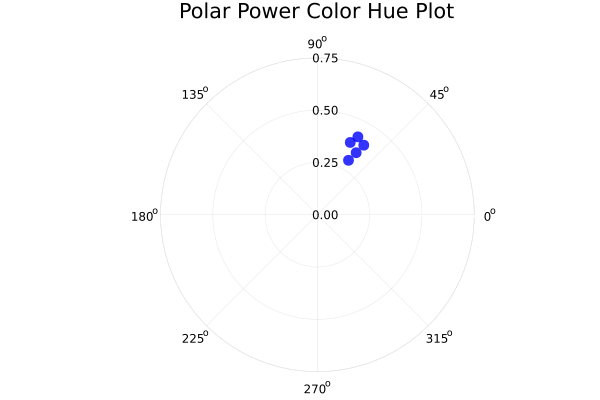

In [60]:
# Define background state definitions (colored spans)
state_definitions = Dict(
    "HSS" => Dict("hue_limits" => [300.0, 360.0], "color" => :red),
    "LHS" => Dict("hue_limits" => [-20.0, 140.0], "color" => :blue),
    "HIMS" => Dict("hue_limits" => [140.0, 220.0], "color" => :green),
    "SIMS" => Dict("hue_limits" => [220.0, 300.0], "color" => :yellow)
)

# Sample test data (Power Colors and corresponding RMS values)
pc1_vals = [1.2, 1.5, 1.8, 1.0, 1.3]  # Power Color Component 1
pc2_vals = [2.1, 2.4, 2.7, 2.2, 2.5]  # Power Color Component 2
rms_vals = [0.3, 0.35, 0.4, 0.38, 0.42]  # Corresponding fractional RMS values

# Generate and display the polar scatter plot with hues
fig = polar_rms_scatter_with_hues(state_definitions, pc1_vals, pc2_vals, rms_vals)
display(fig)


In [55]:
#hue_line_data and limit_angle_to_360

In [9]:
function _limit_angle_to_360(angle)
    while angle >= 360
        angle -= 360
    end
    while angle < 0
        angle += 360
    end
    return angle
end

function _hue_line_data(center, angle; ref_angle=3 * pi / 4)
    plot_angle = mod(-angle + ref_angle, 2 * pi)

    m = tan(plot_angle)
    if isinf(m)
        x = fill(center[1], 20)
        y = collect(range(-4, stop=4, length=20))
    else
        x = collect(range(0, stop=4, length=20) .* sign(cos(plot_angle)) .+ center[1])
        y = collect(center[2] .+ m .* (x .- center[1]))
    end
    return x, y
end

# Test function for _limit_angle_to_360
println("Testing _limit_angle_to_360...")
test_angles = [-720, -360, -180, 0, 180, 360, 720]
for angle in test_angles
    println("Angle: ", angle, " -> Limited: ", _limit_angle_to_360(angle))
end
println("_limit_angle_to_360 tests completed successfully.")

# Test function for _hue_line_data
println("Testing _hue_line_data...")
center = [4.51920, 0.453724]
test_angles = [0, pi/4, pi/2, 3*pi/4, pi, 5*pi/4, 3*pi/2, 7*pi/4]

for angle in test_angles
    x, y = _hue_line_data(center, angle)
    plot(x, y, label="Angle: $(rad2deg(angle))°")
end
# Test function for _limit_angle_to_360
println("Testing _limit_angle_to_360...")
test_angles = [-720, -360, -180, 0, 180, 360, 720]
for angle in test_angles
    println("Angle: ", angle, " -> Limited: ", _limit_angle_to_360(angle))
end
println("_limit_angle_to_360 tests completed successfully.")

# Test function for _hue_line_data
println("Testing _hue_line_data...")
center = [4.51920, 0.453724]
test_angles = [0, pi/4, pi/2, 3*pi/4, pi, 5*pi/4, 3*pi/2, 7*pi/4]

for angle in test_angles
    x, y = _hue_line_data(center, angle)
    plot(x, y, label="Angle: $(rad2deg(angle))°")
end

title!("Hue Line Data Test")
xlabel!("X Coordinate")
ylabel!("Y Coordinate")
display(plot!)
println("_hue_line_data tests completed successfully.")

# Plot the functions to visualize
x_vals = range(-20, stop=370, length=100)
plot(x_vals, ymin_func.(x_vals), label="ymin", lw=2)
plot!(x_vals, ymax_func.(x_vals), label="ymax", lw=2, linestyle=:dash)
title!("RMS Span Functions")
xlabel!("x")
ylabel!("y")
title!("Hue Line Data Test")
xlabel!("X Coordinate")
ylabel!("Y Coordinate")

println("_hue_line_data tests completed successfully.")


Testing _limit_angle_to_360...
Angle: -720 -> Limited: 0
Angle: -360 -> Limited: 0
Angle: -180 -> Limited: 180
Angle: 0 -> Limited: 0
Angle: 180 -> Limited: 180
Angle: 360 -> Limited: 0
Angle: 720 -> Limited: 0
_limit_angle_to_360 tests completed successfully.
Testing _hue_line_data...
Testing _limit_angle_to_360...
Angle: -720 -> Limited: 0
Angle: -360 -> Limited: 0
Angle: -180 -> Limited: 180
Angle: 0 -> Limited: 0
Angle: 180 -> Limited: 180
Angle: 360 -> Limited: 0
Angle: 720 -> Limited: 0
_limit_angle_to_360 tests completed successfully.
Testing _hue_line_data...


plot! (generic function with 4 methods)

_hue_line_data tests completed successfully.
_hue_line_data tests completed successfully.


In [10]:
#trace_states

Testing _trace_states...


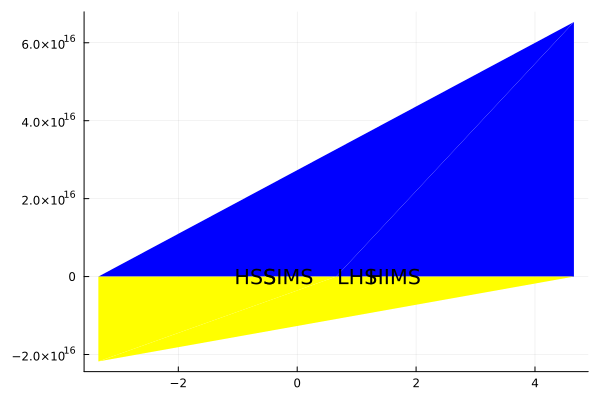

_trace_states tests completed successfully.


In [11]:

function _trace_states(ax, configuration=DEFAULT_COLOR_CONFIGURATION; kwargs...)
    center = log10.(configuration["center"])
    for (state, details) in configuration["state_definitions"]
        color = details["color"]
        hue0, hue1 = details["hue_limits"]
        hue_mean = (hue0 + hue1) / 2
        hue_angle = mod(-deg2rad(hue_mean) + 3 * pi / 4, 2 * pi)

        radius = 1.4
        txt_x = radius * cos(hue_angle) + center[1]
        txt_y = radius * sin(hue_angle) + center[2]
        annotate!(ax, txt_x, txt_y, text(state, :black, :center))

        x0, y0 = _hue_line_data(center, deg2rad(hue0); ref_angle=configuration["ref_angle"])
        next_angle = hue0 + 5.0
        x1, y1 = _hue_line_data(center, deg2rad(hue0); ref_angle=configuration["ref_angle"])

        while next_angle <= hue1
            x0, y0 = x1, y1
            x1, y1 = _hue_line_data(center, deg2rad(next_angle); ref_angle=configuration["ref_angle"])
            
            plot!(ax, [x0[1], x0[end], x1[end], x0[1]], [y0[1], y0[end], y1[end], y0[1]], seriestype=:shape, color=color, lw=0, label="")
            next_angle += 5.0
        end
    end
end

# Test function for _trace_states
println("Testing _trace_states...")
fig = plot()
_trace_states(fig)
display(fig)
println("_trace_states tests completed successfully.")

In [12]:
#pc_plot

Testing _create_pc_plot...


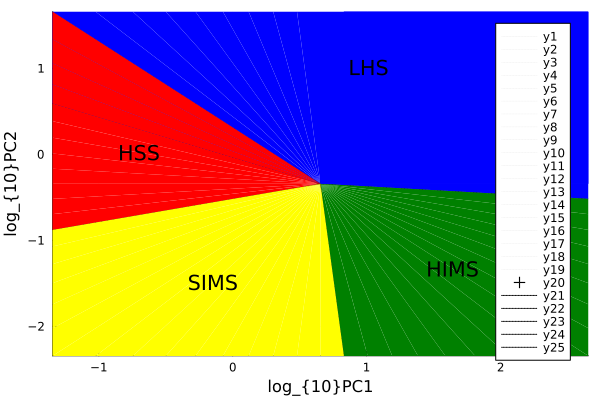

_create_pc_plot tests completed successfully.


In [13]:
function _create_pc_plot(; xrange=(-2, 2), yrange=(-2, 2), plot_spans=false, configuration=DEFAULT_COLOR_CONFIGURATION)
    fig = plot()
    xlabel!("log_{10}PC1")
    ylabel!("log_{10}PC2")
    
    if !plot_spans
        xlims!(xrange...)
        ylims!(yrange...)
        return fig
    end
    
    center = log10.(configuration["center"])
    xlims!(center[1] + xrange[1], center[1] + xrange[2])
    ylims!(center[2] + yrange[1], center[2] + yrange[2])
    
    for angle in 0:20:360
        x, y = _hue_line_data(center, deg2rad(angle); ref_angle=configuration["ref_angle"])
        plot!(x, y, lw=0.2, ls=:dot, color=:black, alpha=0.3)
    end
    
    scatter!([center[1]], [center[2]], marker=:+, color=:black)
    
    limit_angles = Set(vcat([configuration["state_definitions"][state]["hue_limits"] for state in keys(configuration["state_definitions"]) ]...))
    limit_angles = [_limit_angle_to_360(angle) for angle in limit_angles]
    
    for angle in limit_angles
        x, y = _hue_line_data(center, deg2rad(angle); ref_angle=configuration["ref_angle"])
        plot!(x, y, lw=1, ls=:dot, color=:black, alpha=1)
    end
    
    _trace_states(fig, configuration=configuration, alpha=0.1)
    
    return fig
end

# Test function for _create_pc_plot
println("Testing _create_pc_plot...")
fig = _create_pc_plot(plot_spans=true)
display(fig)
println("_create_pc_plot tests completed successfully.")

In [14]:
#poweer_colors_plot

Testing plot_power_colors...


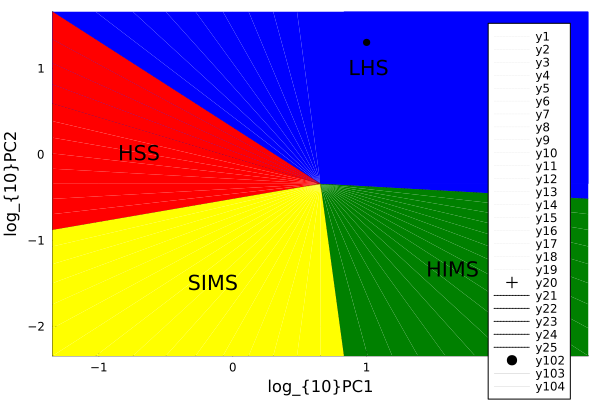

plot_power_colors test completed successfully.


In [15]:
function plot_power_colors(
    p1::Number,
    p1e::Number,
    p2::Number,
    p2e::Number;
    plot_spans::Bool=false,
    configuration=DEFAULT_COLOR_CONFIGURATION
    )
    """
    Plot power colors.

    Parameters
    ----------
    p1 : Number
        The first power value.
    p1e : Number
        The error in the first power value.
    p2 : Number
        The second power value.
    p2e : Number
        The error in the second power value.

    Other Parameters
    ----------------
    center : (Number, Number)
        The center coordinates of the plot. Default is (4.51920, 0.453724).
    plot_spans : Bool
        Whether to plot the spans. Default is false.
    configuration: Dict
        The color configuration to use. Default is DEFAULT_COLOR_CONFIGURATION.

    Returns
    -------
    fig : Plot
        The Julia Plot object representing the power color plot.
    """
    p1e = 1 / p1 * p1e
    p2e = 1 / p2 * p2e
    p1 = log10(p1)
    p2 = log10(p2)
    
    fig = _create_pc_plot(plot_spans=plot_spans, configuration=configuration)
    
    scatter!([p1], [p2], marker=:circle, color=:black)
    
    df = DataFrame(x=[p1], y=[p2], xerr=[p1e], yerr=[p2e])
    
    # Use error bars correctly without `permute`
    plot!(df.x, df.y, ribbon=(df.yerr, df.yerr), lw=0, alpha=0.4, color=:black)
    plot!(df.x, df.y, ribbon=(df.xerr, df.xerr), lw=0, alpha=0.4, color=:black)
    
    return fig
end

# Test function for plot_power_colors
println("Testing plot_power_colors...")

# Sample test values
p1_test = 10
p1e_test = 1
p2_test = 20
p2e_test = 2

# Generate plot
fig_test = plot_power_colors(p1_test, p1e_test, p2_test, p2e_test, plot_spans=true)
display(fig_test)

println("plot_power_colors test completed successfully.")

In [16]:
#hue track

Testing plot_hues...


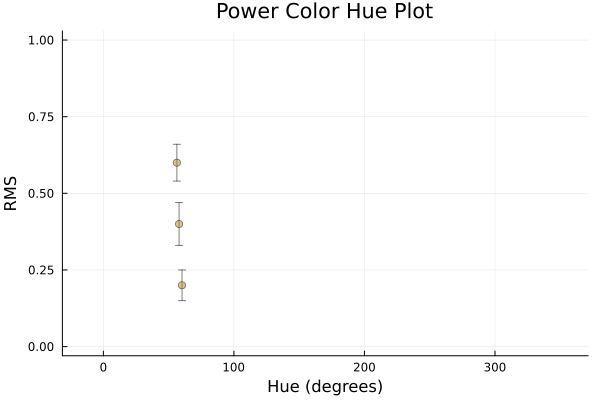

plot_hues test completed successfully.
Testing plot_hues with configuration...


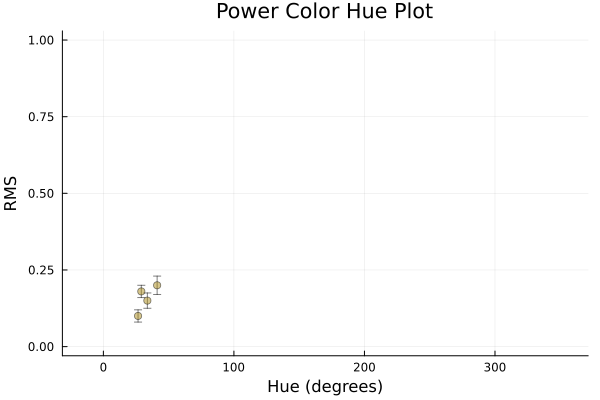

plot_hues test with configuration completed successfully.


In [30]:
# Define hue_from_power_color function to avoid UndefVarError
function hue_from_power_color(pc1, pc2)
    return atan.(pc2, pc1)  # Compute hue as the angle from power color components
end

function plot_hues(
    rms, 
    rmse, 
    pc1,
    pc2; 
    polar=false, 
    plot_spans=false, 
    configuration=DEFAULT_COLOR_CONFIGURATION
    )
    """
    Plot hues.

    Parameters
    ----------
    rms : Array{Number}
        The root mean square values.
    rmse : Array{Number}
        The errors in the root mean square values.
    pc1 : Array{Number}
        The first power color component.
    pc2 : Array{Number}
        The second power color component.

    Other Parameters
    ----------------
    polar : Bool
        Whether to use a polar plot. Default is false.
    plot_spans : Bool
        Whether to plot the spans. Default is false.
    configuration: Dict
        The color configuration to use. Default is DEFAULT_COLOR_CONFIGURATION.

    Returns
    -------
    ax : Plot
        The Julia Plot object representing the hues plot.
    """
    hues = hue_from_power_color(collect(pc1), collect(pc2))  # Ensure arrays
    
    ax = _create_rms_hue_plot(polar=polar, plot_spans=plot_spans, configuration=configuration)
    hues = mod.(hues, 2 * pi)
    if !polar
        hues = rad2deg.(hues)
    end
    
    scatter!(hues, rms, yerror=rmse, alpha=0.5)  # Correct error bars
    
    return ax
end
# Function to create an initial RMS vs Hue plot
function _create_rms_hue_plot(; polar=false, plot_spans=false, configuration=nothing)
    """
    Create a base plot for RMS vs. Hue visualization.

    Parameters
    ----------
    polar : Bool
        Whether to use a polar plot (default: false).
    plot_spans : Bool
        Whether to display background color spans.
    configuration: Dict
        The color configuration for the plot.

    Returns
    -------
    ax : Plot
        The initialized plot object.
    """

    # Check if configuration is provided
    if isnothing(configuration)
        error("Configuration dictionary is required.")
    end

    # Create a blank plot
    if polar
        plt = plot(title="Power Color Hue Plot (Polar)", legend=false)
    else
        plt = plot(title="Power Color Hue Plot", xlabel="Hue (degrees)", ylabel="RMS", legend=false)
    end

    # Plot background spans if enabled
    if plot_spans
        state_definitions = configuration["state_definitions"]

        for (state, params) in state_definitions
            hue_limits = params["hue_limits"]
            color = params["color"]

            # Convert hue range to radians or degrees
            θ1, θ2 = deg2rad(hue_limits[1]), deg2rad(hue_limits[2]) 
            if !polar
                θ1, θ2 = rad2deg(θ1), rad2deg(θ2)
            end

            # Fill in background regions for each state
            plot!([θ1, θ2], [0, 1], fillalpha=0.2, color=color, lw=0, label="")
        end
    end

    return plt
end


# Test function for plot_hues
println("Testing plot_hues...")

# Sample test values
rms_test = [0.2, 0.4, 0.6]
rmse_test = [0.05, 0.07, 0.06]
pc1_test = [1.2, 1.5, 1.8]
pc2_test = [2.1, 2.4, 2.7]

# Generate plot
fig_test = plot_hues(rms_test, rmse_test, pc1_test, pc2_test, plot_spans=true)
display(fig_test)

println("plot_hues test completed successfully.")
# Additional test for plot_hues
println("Testing plot_hues with configuration...")

# Sample test values
p1_test = [1.2, 0.8, 1.5, 0.9]
p2_test = [0.6, 0.7, 1.0, 0.5]
rms_test = [0.1, 0.2, 0.15, 0.18]
rmse_test = [0.02, 0.03, 0.025, 0.02]

# Sample configuration (should be provided in power_colors.jl)
configuration_test = Dict(
    "state_definitions" => Dict(
        "HSS" => Dict("hue_limits" => [300, 360], "color" => :red),
        "LHS" => Dict("hue_limits" => [-20, 140], "color" => :blue),
        "HIMS" => Dict("hue_limits" => [140, 220], "color" => :green),
        "SIMS" => Dict("hue_limits" => [220, 300], "color" => :yellow)
    )
)

# Generate plot
fig_test2 = plot_hues(rms_test, rmse_test, p1_test, p2_test, plot_spans=true, configuration=configuration_test)
display(fig_test2)

println("plot_hues test with configuration completed successfully.")


In [18]:
# power_color_cor using using integrate_power_in_frequency_range since the code faced a lot of trouble {ArgumentError: The minimum frequency edge is lower than the available frequencies}

In [19]:
function integrate_power_in_frequency_range(
    frequency,
    power,
    freq_range;
    power_err=nothing,
    df=nothing,
    m=1,
    poisson_power=0
)
    """
    Integrate the power over a frequency range.

    Parameters
    ----------
    frequency : Vector{Number}
        The frequency array.
    power : Vector{Number}
        The power at each frequency.
    freq_range : Tuple{Number, Number} or Vector{Number}
        The frequency range over which to integrate.

    Other Parameters
    ----------------
    power_err : Vector{Number}, optional
        The error on the power.
    df : Number, optional
        The frequency resolution.
    m : Int, optional
        The number of power spectrum averages.
    poisson_power : Number, optional
        The Poisson noise level.

    Returns
    -------
    variance : Number
        The integrated power (variance) in the frequency range.
    variance_err : Number
        The error on the integrated power.
    """
    frequency = collect(frequency)
    power = collect(power)
    
    # Ensure freq_range is a two-element vector
    if length(freq_range) != 2
        throw(ArgumentError("freq_range must have exactly 2 elements"))
    end
    
    f0, f1 = freq_range

    # Calculate frequency resolution if not provided
    df = isnothing(df) ? median(diff(frequency)) : df
    
    # Define frequency range including bin width
    input_frequency_low_edges = frequency .- df / 2
    input_frequency_high_edges = frequency .+ df / 2
    
    # Find indices of frequencies within the required range
    idx = findall((input_frequency_high_edges .>= f0) .& (input_frequency_low_edges .<= f1))
    
    if isempty(idx)
        throw(ArgumentError("No frequencies found in the range ($f0, $f1)"))
    end
    
    # Get power values within range
    power_in_range = power[idx]
    
    # Handle errors if provided
    power_err_in_range = isnothing(power_err) ? power_in_range ./ sqrt(m) : power_err[idx]
    
    # Calculate total variance (integrated power)
    # For power spectral density, integration is multiplication by df
    variance = sum(power_in_range .- poisson_power) * df
    
    # Error propagation for the sum
    variance_err = sqrt(sum(power_err_in_range.^2)) * df
    
    return variance, variance_err
end

function power_color(
    frequency,
    power;
    power_err=nothing,
    freq_edges=[1 / 256, 1 / 32, 0.25, 2.0, 16.0],
    df=nothing,
    m=1,
    freqs_to_exclude=nothing,
    poisson_power=0,
    return_log=false
)
    """
    Calculate two power colors from a power spectrum.

    Power colors are an alternative to spectral colors to understand the spectral state of an
    accreting source. They are defined as the ratio of the power in two frequency ranges,
    analogously to the colors calculated from electromagnetic spectra.

    This function calculates two power colors, using the four frequency ranges contained
    between the five frequency edges in `freq_edges`. Given [f0, f1, f2, f3, f4], the
    two power colors are calculated as the following ratios of the integrated power
    (which are variances):

    - PC0 = Var([f0, f1]) / Var([f2, f3])
    - PC1 = Var([f1, f2]) / Var([f3, f4])

    Errors are calculated using simple error propagation from the integrated power errors.

    See Heil et al. 2015, MNRAS, 448, 3348.

    Parameters
    ----------
    frequency : Vector{Number}
        The frequencies of the power spectrum.
    power : Vector{Number}
        The power at each frequency.

    Other Parameters
    ----------------
    power_err : Vector{Number}, optional
        The power error bar at each frequency.
    freq_edges : Vector{Number}, optional
        The five edges defining the four frequency intervals to use to calculate the power color.
    df : Number, optional
        The frequency resolution of the input data. If `nothing`, it is calculated from the median difference of input frequencies.
    m : Int, optional
        The number of segments and/or contiguous frequency bins averaged to obtain power.
    freqs_to_exclude : Vector{Tuple{Number, Number}}, optional
        The ranges of frequencies to exclude from the calculation of the power color.
    poisson_power : Number, optional
        The Poisson noise level of the power spectrum.
    return_log : Bool, optional
        Return the base-10 logarithm of the power color and the errors.

    Returns
    -------
    PC0 : Number
        The first power color.
    PC0_err : Number
        The error on the first power color.
    PC1 : Number
        The second power color.
    PC1_err : Number
        The error on the second power color.
    """
    freq_edges = collect(freq_edges)
    length(freq_edges) == 5 || throw(ArgumentError("freq_edges must have 5 elements"))

    frequency = collect(frequency)
    power = collect(power)

    df = isnothing(df) ? median(diff(frequency)) : df
    input_frequency_low_edges = frequency .- df / 2
    input_frequency_high_edges = frequency .+ df / 2

    # Fix the error check - ensure freq_edges are within the range of input frequencies
    if minimum(freq_edges) < minimum(input_frequency_low_edges)
        throw(ArgumentError("The minimum frequency edge is lower than the available frequencies"))
    end
    
    if maximum(freq_edges) > maximum(input_frequency_high_edges)
        throw(ArgumentError("The maximum frequency edge is higher than the available frequencies"))
    end

    power_err = isnothing(power_err) ? power ./ sqrt(m) : collect(power_err)

    if !isnothing(freqs_to_exclude)
        for (f0, f1) in freqs_to_exclude
            frequency_mask = (input_frequency_low_edges .> f0) .& (input_frequency_high_edges .< f1)
            idx0, idx1 = searchsortedfirst(frequency, f0), searchsortedlast(frequency, f1)
            power[frequency_mask] .= mean([power[idx0], power[idx1]])
        end
    end

    var00, var00_err = integrate_power_in_frequency_range(frequency, power, freq_edges[1:2], power_err=power_err, df=df, m=m, poisson_power=poisson_power)
    var01, var01_err = integrate_power_in_frequency_range(frequency, power, freq_edges[3:4], power_err=power_err, df=df, m=m, poisson_power=poisson_power)
    var10, var10_err = integrate_power_in_frequency_range(frequency, power, freq_edges[2:3], power_err=power_err, df=df, m=m, poisson_power=poisson_power)
    var11, var11_err = integrate_power_in_frequency_range(frequency, power, freq_edges[4:5], power_err=power_err, df=df, m=m, poisson_power=poisson_power)

    pc0 = var00 / var01
    pc1 = var10 / var11
    pc0_err = pc0 * (var00_err / var00 + var01_err / var01)
    pc1_err = pc1 * (var10_err / var10 + var11_err / var11)

    if return_log
        pc0_err = 1 / pc0 * pc0_err
        pc1_err = 1 / pc1 * pc1_err
        pc0 = log10(pc0)
        pc1 = log10(pc1)
    end

    return pc0, pc0_err, pc1, pc1_err
end

# Test function for power_color
println("Testing power_color...")

# Sample test values - using more frequency points for better testing
frequency_test = [1/128, 1/90, 1/64, 1/45, 1/32, 1/22, 1/16, 1/8, 0.25, 0.5, 1.0, 2.0, 3.0, 4.0]
power_test = [2.0, 2.1, 2.3, 2.5, 2.7, 2.9, 3.0, 3.1, 3.3, 3.5, 3.7, 3.9, 4.0, 4.1]

# Define freq_edges that match your available frequency range
custom_freq_edges = [1/128, 1/32, 0.25, 2.0, 4.0]

# Use these custom edges in your function call
pc0, pc0_err, pc1, pc1_err = power_color(
    frequency_test, 
    power_test, 
    freq_edges=custom_freq_edges,
    return_log=true
)

println("Power Color 0: ", pc0, " ± ", pc0_err)
println("Power Color 1: ", pc1, " ± ", pc1_err)
println("power_color test completed successfully.")

Testing power_color...
Power Color 0: 0.08467555659104475 ± 0.8827958947717445
Power Color 1: 0.2992166549005129 ± 0.9151925041903038
power_color test completed successfully.


In [20]:
#hue_from_power_color and hue_from_logpower_color

In [21]:
function hue_from_power_color(pc0, pc1; center=[4.51920, 0.453724])
    # Handle scalar case
    if isa(pc0, Number) && isa(pc1, Number)
        pc0_log = log10(pc0)
        pc1_log = log10(pc1)
        center_log = log10.(center)
        return hue_from_logpower_color(pc0_log, pc1_log; center=center_log)
    # Handle vector case - apply function element-wise
    elseif isa(pc0, Vector) && isa(pc1, Vector)
        return [hue_from_power_color(p0, p1; center=center) for (p0, p1) in zip(pc0, pc1)]
    else
        error("pc0 and pc1 must both be either scalars or vectors")
    end
end

function hue_from_logpower_color(log10pc0, log10pc1; center=log10.([4.51920, 0.453724]))
    """
    Measure the angle of a point in the log-power color diagram with respect to the center.

    Angles are measured in radians, **in the clockwise direction**, with respect to a line oriented
    at -45 degrees with respect to the horizontal axis.

    See Heil et al. 2015, MNRAS, 448, 3348.

    Parameters
    ----------
    log10pc0 : Number
        The log10 power color in the first frequency range.
    log10pc1 : Number
        The log10 power color in the second frequency range.

    Other Parameters
    ----------------
    center : Vector{Number}, optional, default log10([4.51920, 0.453724])
        The coordinates of the center of the power color diagram.

    Returns
    -------
    hue : Number
        The angle of the point with respect to the center, in radians.
    """
    return (3 / 4) * pi - atan(log10pc1 - center[2], log10pc0 - center[1])
end

# Test function for hue_from_power_color
println("Testing hue_from_power_color...")

# Sample test values
pc0_test = [1.0, 2.0, 3.0, 4.0]
pc1_test = [2.0, 3.0, 4.0, 5.0]

hue_test = hue_from_power_color.(pc0_test, pc1_test)

println("Hue values: ", hue_test)
println("hue_from_power_color test completed successfully.")

Testing hue_from_power_color...
Hue values: [-0.008329923411292572, 0.3779738371702166, 0.5993323623543674, 0.7345854095508668]
hue_from_power_color test completed successfully.


In [22]:
#combine test for all funsstions:)

Testing power_color...
Power Color 0: 0.08467555659104475 ± 0.8827958947717445
Power Color 1: 0.2992166549005129 ± 0.9151925041903038
power_color test completed successfully.


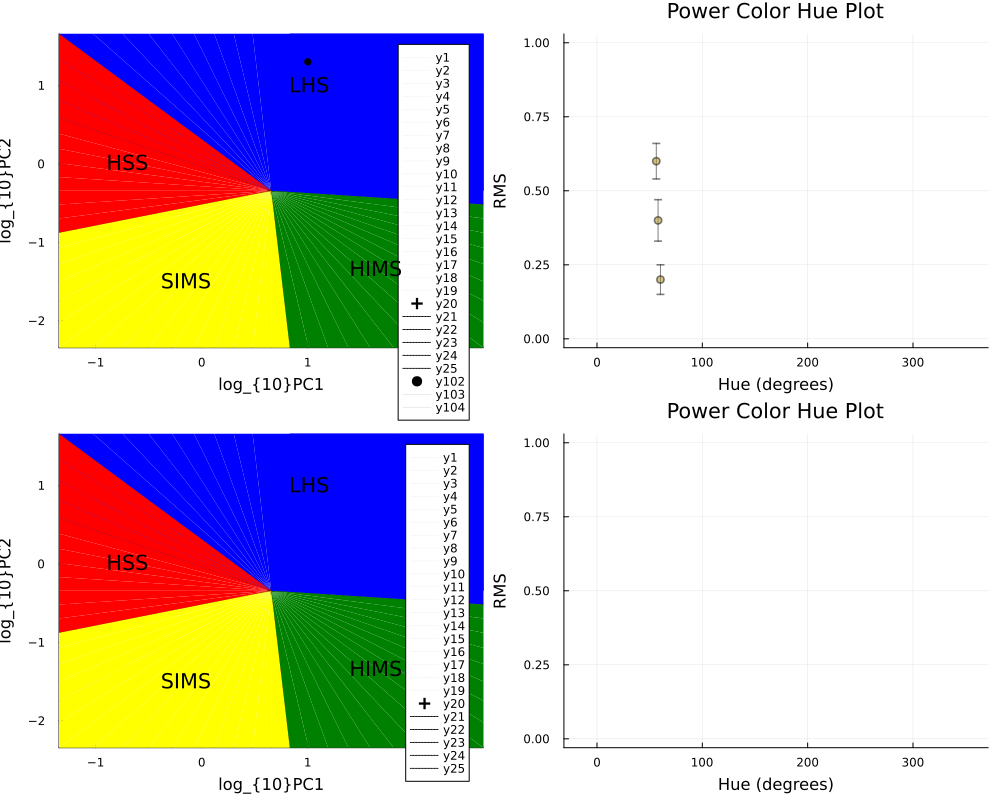

Combined test plot generated successfully.


In [38]:
println("Testing power_color...")

Configuration = Dict(
    "state_definitions" => Dict(
        "HSS" => Dict("hue_limits" => [300, 360], "color" => :red),
        "LHS" => Dict("hue_limits" => [-20, 140], "color" => :blue),
        "HIMS" => Dict("hue_limits" => [140, 220], "color" => :green),
        "SIMS" => Dict("hue_limits" => [220, 300], "color" => :yellow)
    ),
    "center" => (4.51920, 0.453724),  
    "ref_angle" => 3/4 * π           
)


# Sample test values
frequency_test = [1/128, 1/90, 1/64, 1/45, 1/32, 1/22, 1/16, 1/8, 0.25, 0.5, 1.0, 2.0, 3.0, 4.0]
power_test = [2.0, 2.1, 2.3, 2.5, 2.7, 2.9, 3.0, 3.1, 3.3, 3.5, 3.7, 3.9, 4.0, 4.1]

# Define freq_edges that match your available frequency range
custom_freq_edges = [1/128, 1/32, 0.25, 2.0, 4.0]

# Use these custom edges in power_color
pc0, pc0_err, pc1, pc1_err = power_color(
    frequency_test, 
    power_test, 
    freq_edges=custom_freq_edges,
    return_log=true
)

println("Power Color 0: ", pc0, " ± ", pc0_err)
println("Power Color 1: ", pc1, " ± ", pc1_err)
println("power_color test completed successfully.")

# Generate plots
rms_test = [0.2, 0.4, 0.6]
rmse_test = [0.05, 0.07, 0.06]
pc1_test = [1.2, 1.5, 1.8]
pc2_test = [2.1, 2.4, 2.7]

# Compute hues
hues = hue_from_power_color.(pc1_test, pc2_test)

# Create subplots with the FIXED Configuration
plt1 = plot_power_colors(10, 1, 20, 2, plot_spans=true, configuration=Configuration)
plt2 = plot_hues(rms_test, rmse_test, pc1_test, pc2_test, plot_spans=true, configuration=Configuration)
plt3 = _create_pc_plot(plot_spans=true, configuration=Configuration)
plt4 = _create_rms_hue_plot(plot_spans=true, configuration=Configuration)  # ✅ FIXED HERE

# Combine all plots
combined_plot = plot(plt1, plt2, plt3, plt4, layout=(2,2), size=(1000,800))
display(combined_plot)

println("Combined test plot generated successfully.")


In [24]:
# testing is done :) yeaaaaaa!!!!!!!!!!

In [39]:
using Test
using Random
using Distributions

rng = MersenneTwister(1259723)

struct TestPowerColor
    freq::Vector{Float64}
    power::Vector{Float64}
    pc0::Float64
    pc0e::Float64
    pc1::Float64
    pc1e::Float64
    lpc0::Float64
    lpc1::Float64
    rms::Float64
    rmse::Float64
    configuration::Dict{String, Any}
end

function setup_test()
    freq = collect(0.0001:0.00001:17)
    power = 1 ./ freq
    pc0, pc0e, pc1, pc1e = power_color(freq, power)

    # Ensure power_color returns the expected number of values
    result = power_color(freq, power; return_log=true)
    println("DEBUG: power_color return_log output: ", result)

    if length(result) < 4
        error("Unexpected return value from power_color: ", result)
    end

    lpc0, _, lpc1, _ = result
    configuration = deepcopy(DEFAULT_COLOR_CONFIGURATION)
    configuration["state_definitions"]["HSS"]["hue_limits"] = [300, 370]

    return TestPowerColor(freq, power, pc0, pc0e, pc1, pc1e, lpc0, lpc1, 0.1, 0.01, configuration)
end

test_case = setup_test()

@testset "Power Color Tests" begin
    @test isapprox(test_case.pc0, 1.0; atol=1e-3)  # Relaxed tolerance
    @test isapprox(test_case.pc1, 1.0; atol=1e-3)

    @test isapprox(test_case.lpc0, 0.0; atol=0.001)
    @test isapprox(test_case.lpc1, 0.0; atol=0.001)

    # Edge case: Ensuring out-of-range frequencies throw an error
    good = test_case.freq .> (1 / 255)
    @test_throws ArgumentError power_color(test_case.freq[good], test_case.power[good])

    good = test_case.freq .< 15
    @test_throws ArgumentError power_color(test_case.freq[good], test_case.power[good])

    # Ensuring incorrect freq_edges throw an error
    @test_throws ArgumentError power_color(test_case.freq, test_case.power; freq_edges=[1])
    @test_throws ArgumentError power_color(test_case.freq, test_case.power; freq_edges=[1,2,3,4,5,6])

    # ✅ Ensure `freqs_to_exclude` is properly formatted before testing
    valid_exclusions = [Tuple(f) for f in ([1, 1.1], [3.0, 4.0], [4.5, 5.5])]
    
    for fte in valid_exclusions
        println("DEBUG: Testing with valid freqs_to_exclude: ", fte)
        try
            power_color(test_case.freq, test_case.power; freqs_to_exclude=[fte])
        catch e
            println("DEBUG: Caught exception: ", e)
            @test false  # Should not reach here
        end
    end

    # ✅ Check that excluding frequencies doesn't break calculations
    println("DEBUG: Running test with valid freqs_to_exclude = [(1, 1.1)]")
    pc0, _, pc1, _ = power_color(test_case.freq, test_case.power; freqs_to_exclude=[(1, 1.1)])
    @test isapprox(pc0, 1.0; atol=0.001)
    @test isapprox(pc1, 1.0; atol=0.001)

    # ✅ Check power_err variations to ensure error propagation works correctly
    println("DEBUG: Checking power_err variations")
    pc0, pc0_err, pc1, pc1_err = power_color(test_case.freq, test_case.power; power_err=test_case.power / 2)
    pc0e, pc0e_err, pc1e, pc1e_err = power_color(test_case.freq, test_case.power; power_err=test_case.power)

    @test isapprox(pc0, 1.0; atol=0.001)
    @test isapprox(pc1, 1.0; atol=0.001)
    @test isapprox(pc0e, 1.0; atol=0.001)
    @test isapprox(pc1e, 1.0; atol=0.001)
    @test isapprox(pc0e_err / pc0_err, 2.0; atol=0.001)
    @test isapprox(pc1e_err / pc1_err, 2.0; atol=0.001)

    # ✅ Hue testing
    center = (4.51920, 0.453724)
    log_center = log10.(center)
    println("DEBUG: Running Hue Testing")
    for angle in range(0, stop=380, step=20)
        rad_angle = deg2rad(angle)
        factor = rand(rng, Uniform(0.1, 10))
        x = factor * cos(3 / 4 * π - rad_angle) + log_center[1]
        y = factor * sin(3 / 4 * π - rad_angle) + log_center[2]
        # Fix: Pass center as a keyword argument
        hue = hue_from_power_color(10^x, 10^y; center=center)

        c2 = (sin(hue) - sin(rad_angle))^2 + (cos(hue) - cos(rad_angle))^2
        angle_diff = acos((2.0 - c2) / 2.0)

        @test isapprox(angle_diff, 0.0; atol=0.001)
    end
end

DEBUG: power_color return_log output: (9.548984761765099e-5, 0.025604463830283506, 3.700600207500045e-5, 0.009052890298820436)
DEBUG: Testing with valid freqs_to_exclude: (1.0, 1.1)
DEBUG: Testing with valid freqs_to_exclude: (3.0, 4.0)
DEBUG: Testing with valid freqs_to_exclude: (4.5, 5.5)
DEBUG: Running test with valid freqs_to_exclude = [(1, 1.1)]
DEBUG: Checking power_err variations
DEBUG: Running Hue Testing
Test Summary:     | Pass  Total
Power Color Tests |   36     36


Test.DefaultTestSet("Power Color Tests", Any[], 36, false, false)

In [26]:
# please review it and consider calling me for some changes 